<a href="https://colab.research.google.com/github/prayas99/IE643_Project/blob/main/IE_DeepCodies_NLPApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Change Runtime to GPU for best experiance**

If getting error "No such file or directory: /usr/local/lib/python3.6/dist-packages/tqdm-4.41.1.dist-info/METADATA" when running the follwing cell, restart runtime and run again

In [ ]:
#@title <font size="5"> ឵឵<i>← Install Required Libraries</font> { vertical-output: true }
from IPython.display import clear_output
import os, urllib.request
HOME = os.path.expanduser("~")
pathDoneCMD = f'{HOME}/doneCMD.sh'
if not os.path.exists(f"{HOME}/.ipython/ttmg.py"):
    hCode = "https://raw.githubusercontent.com/yunooooo/gcct/master/res/ttmg.py"
    urllib.request.urlretrieve(hCode, f"{HOME}/.ipython/ttmg.py")

from ttmg import (
    loadingAn,
    textAn,
)
loadingAn(name="lds")
textAn("Installing Dependencies...", ty='twg')
import seaborn as sns
os.system('pip install transformers')
os.system('pip install sentencepiece')
os.system('pip install -U simpletransformers  ')
os.system('pip install tweet-preprocessor')
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import preprocessor as p
from tqdm.notebook import tqdm
tqdm.pandas()
import pickle 
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import XLNetLMHeadModel
# 
import random
clear_output()
print('Installation finished.')

Installation finished.


# Text Generator training

In [ ]:
%%time
from transformers import XLNetTokenizer, XLNetLMHeadModel
import torch
tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
model = XLNetLMHeadModel.from_pretrained('xlnet-large-cased')


CPU times: user 26.5 s, sys: 4.35 s, total: 30.9 s
Wall time: 31.8 s


In [ ]:
model

XLNetLMHeadModel(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 1024)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=1024, out_features=4096, bias=True)
          (layer_2): Linear(in_features=4096, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((1024,), eps=1e-12, el

In [ ]:
# saving the model 
import pickle 
#pickle_out = open("/content/drive/MyDrive/IE643_project_resources/textGen_trained.pkl", mode = "wb") 
pickle_out = open("/content/textGen_trained.pkl", mode = "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()

In [ ]:
pickle_out = open("/content/tokenizer.pkl", mode = "wb") 
pickle.dump(tokenizer, pickle_out) 
pickle_out.close()

# Text Classification training

In [ ]:
!gdown --id 1jlGYE1szrsCxW5xzNrsGsIlNE1bsYsRT

Downloading...
From: https://drive.google.com/uc?id=1jlGYE1szrsCxW5xzNrsGsIlNE1bsYsRT
To: /content/train.csv
100% 988k/988k [00:00<00:00, 15.6MB/s]


In [ ]:
!gdown --id 1BCfOBj_qCT_N6PyROUeYJV-2QX-SY5k9

Downloading...
From: https://drive.google.com/uc?id=1BCfOBj_qCT_N6PyROUeYJV-2QX-SY5k9
To: /content/test.csv
100% 421k/421k [00:00<00:00, 6.66MB/s]


In [ ]:
import pandas as pd
import numpy as np

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_train.head()

df_train.target.value_counts()

print(f"Keyword column has {df_train.keyword.isnull().sum()/df_train.shape[0]*100}% null values")
print(f"Location column has {df_train.location.isnull().sum()/df_train.shape[0]*100}% null values")



# function to clean @, #, and links from tweets
def clean_text(text):
 text = text.replace("#","")
 return p.clean(text)

# Appling function to train and test data
from tqdm.notebook import tqdm
tqdm.pandas()

df_train['clean_text'] = df_train['text'].astype(str).progress_map(clean_text)
df_test['clean_text'] = df_test['text'].astype(str).progress_map(clean_text)

# splitting the data into training and eval dataset
X = df_train['clean_text']
y = df_train['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_df = pd.DataFrame(X_train)
train_df['target'] = y_train

eval_df = pd.DataFrame(X_test)
eval_df['target'] = y_test

train_df.shape, eval_df.shape



Keyword column has 0.8012610009194797% null values
Location column has 33.27203467752528% null values


((6090, 2), (1523, 2))

In [ ]:
df_train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

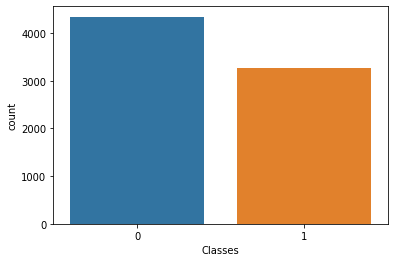

In [ ]:
sns.countplot(x=df_train.target)
plt.xlabel('Classes');
plt.show()

In [ ]:
# We will import ClassificationModel - as we need to solve binary text classification
# We will import ClassificationModel - as we need to solve binary text classification
from simpletransformers.classification import ClassificationModel
import pandas as pd
import logging
import sklearn


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)





# They are lot of arguments to play with

# Create a ClassificationModel
model = ClassificationModel('xlnet', 'xlnet-base-cased', args={'num_train_epochs':1, 'train_batch_size':32, 'max_seq_length':128}) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=sklearn.metrics.accuracy_score)


INFO:filelock:Lock 140239070581704 acquired on /root/.cache/huggingface/transformers/06bdb0f5882dbb833618c81c3b4c996a0c79422fa2c95ffea3827f92fc2dba6b.da982e2e596ec73828dbae86525a1870e513bd63aae5a2dc773ccc840ac5c346.lock


INFO:filelock:Lock 140239070581704 released on /root/.cache/huggingface/transformers/06bdb0f5882dbb833618c81c3b4c996a0c79422fa2c95ffea3827f92fc2dba6b.da982e2e596ec73828dbae86525a1870e513bd63aae5a2dc773ccc840ac5c346.lock


INFO:filelock:Lock 140239019896392 acquired on /root/.cache/huggingface/transformers/9461853998373b0b2f8ef8011a13b62a2c5f540b2c535ef3ea46ed8a062b16a9.3e214f11a50e9e03eb47535b58522fc3cc11ac67c120a9450f6276de151af987.lock


INFO:filelock:Lock 140239019896392 released on /root/.cache/huggingface/transformers/9461853998373b0b2f8ef8011a13b62a2c5f540b2c535ef3ea46ed8a062b16a9.3e214f11a50e9e03eb47535b58522fc3cc11ac67c120a9450f6276de151af987.lock


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

INFO:filelock:Lock 140239019431808 released on /root/.cache/huggingface/transformers/df73bc9f8d13bf2ea4dab95624895e45a550a0f0a825e41fc25440bf367ee3c8.d93497120e3a865e2970f26abdf7bf375896f97fde8b874b70909592a6c785c9.lock


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:387: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:966: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.6734413092759665, 'tp': 492, 'tn': 788, 'fp': 81, 'fn': 162, 'acc': 0.8404464871963231, 'eval_loss': 0.3870220781152785}


In [ ]:
print(result)

{'mcc': 0.6734413092759665, 'tp': 492, 'tn': 788, 'fp': 81, 'fn': 162, 'acc': 0.8404464871963231, 'eval_loss': 0.3870220781152785}


In [ ]:
# saving the model 
pickle_out = open("/content/classifier_trained.pkl", mode = "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()

# Sentiment Analysis training

In [ ]:
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Data Preprcocessing


In [ ]:
!gdown --id 1R0EvosMyr6zL9XUlXxtjR1Q_pzHQ3Uda

Downloading...
From: https://drive.google.com/uc?id=1R0EvosMyr6zL9XUlXxtjR1Q_pzHQ3Uda
To: /content/IMDB Dataset.csv
66.2MB [00:01, 34.5MB/s]


In [ ]:
df = pd.read_csv('/content/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head(20)

,review,sentiment
5026,I bought this movie at a thrift store. Months ...,negative
29517,"A young solicitor from London, Arthur Kidd is ...",positive
26246,The pakage implies that Warren Beatty and Gold...,negative
6223,"Way to go ace! You just made a chilling, gross...",negative
10083,Campfire Tales (1997)<br /><br />An excellent ...,positive
13591,"I'll admit that I've never seen ""Waiting for G...",positive
19363,Crossfire is one of those films from the Forti...,positive
38281,When the American movie industry tries to crit...,negative
17277,Why is it better? Because it's true to the dar...,positive
10839,There have been far too few mainstream films s...,positive


In [ ]:
df = df[:24000]
len(df)

24000

In [ ]:
import re
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

In [ ]:
df['review'] = df['review'].apply(clean_text)

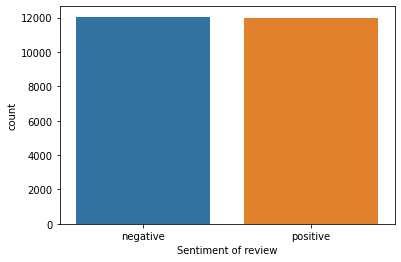

In [ ]:
sns.countplot(x=df.sentiment)
plt.xlabel('Sentiment of review')
plt.show()

In [ ]:
def sentiment2label(sentiment):
    if sentiment == "positive":
        return 1
    else :
        return 0

df['sentiment'] = df['sentiment'].apply(sentiment2label)

In [ ]:
df['sentiment'].value_counts()

0    12006
1    11994
Name: sentiment, dtype: int64

In [ ]:
class_names = ['negative', 'positive']

XLNet Tokenizer

In [ ]:
%%time
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

CPU times: user 56 ms, sys: 10.5 ms, total: 66.5 ms
Wall time: 273 ms


In [ ]:
input_txt = "India is my country. All Indians are my brothers and sisters"
encodings = tokenizer.encode_plus(input_txt, truncation=True,add_special_tokens=True, max_length=16, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=False)

dataset

In [ ]:
class ImdbDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'review_text': review,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.5, random_state=101)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=101)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ImdbDataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
%%time
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)
model = model.to(device)
BATCH_SIZE = 4
MAX_LEN = 512

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

CPU times: user 3.18 s, sys: 453 ms, total: 3.64 s
Wall time: 16.5 s


In [ ]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [ ]:

EPOCHS = 1

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [ ]:
from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].reshape(4,512).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        #print('a')
        
        outputs = model(input_ids=input_ids,truncation=True, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]
        #print('b')
        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1
        if (counter)%100 == 0:
            print('Done %d out of %d batches | %d %% remaining' % (counter,1000,(1-(counter/1000))*100))
        #print(counter)
        if (counter==1000):
          break

    return acc / counter, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(4,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids,truncation=True, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device, 
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '/content/SentimentAnalysis.bin')
        best_accuracy = val_acc

Epoch 1/1
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-st

Done 100 out of 1000 batches | 90 % remaining
Done 200 out of 1000 batches | 80 % remaining
Done 300 out of 1000 batches | 70 % remaining
Done 400 out of 1000 batches | 60 % remaining
Done 500 out of 1000 batches | 50 % remaining
Done 600 out of 1000 batches | 40 % remaining
Done 700 out of 1000 batches | 30 % remaining
Done 800 out of 1000 batches | 19 % remaining
Done 900 out of 1000 batches | 9 % remaining
Done 1000 out of 1000 batches | 0 % remaining
Train loss 0.37979597512360486 Train accuracy 0.91525


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val loss 0.35262277426094324 Val accuracy 0.9303333333333333

CPU times: user 13min 30s, sys: 9min 57s, total: 23min 28s
Wall time: 23min 32s


# Test (Sentiment Analysis)

In [ ]:
%%time
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
BATCH_SIZE = 4
MAX_LEN = 512
class_names = ['Negative', 'Positive']

In [ ]:
!gdown --id 1O_JQeE6YGYdVca1aQKgA-HR5Bh8JCE5d

Downloading...
From: https://drive.google.com/uc?id=1O_JQeE6YGYdVca1aQKgA-HR5Bh8JCE5d
To: /content/SentimentAnalysis.bin
469MB [00:07, 63.7MB/s]


In [ ]:
#model.load_state_dict(torch.load('/content/drive/MyDrive/IE643_project_resources/SentimentAnalysis.bin'))

In [ ]:
model.load_state_dict(torch.load('/content/SentimentAnalysis.bin'))

<All keys matched successfully>

In [ ]:
# test_acc, test_loss = eval_model(
#   model,
#   test_data_loader,
#   device,
#   len(df_test)
# )

# print('Test Accuracy :', test_acc)
# print('Test Loss :', test_loss)

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].reshape(4,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
# y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
#   model,
#   test_data_loader
# )

In [ ]:
# print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.91      0.94      0.93      2976
    positive       0.94      0.91      0.93      3024

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000



On Custom input

In [ ]:
def predict_sentiment(text):
    review_text = text

    encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=False,
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = pad_sequences(encoded_review['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids) 

    attention_mask = pad_sequences(encoded_review['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask) 

    input_ids = input_ids.reshape(1,512).to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    outputs = outputs[0][0].cpu().detach()

    probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
    _, prediction = torch.max(outputs, dim =-1)

    print("Positive score: %.5f" % (probs[1]))
    print("Negative score: %.5f" % (probs[0]))
    #print(f'Review text: {review_text}')
    print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
text = "Movie is the worst one I have ever seen!! The story has no meaning at all"
predict_sentiment(text)

Positive score: 0.0002527328615542501
Negative score: 0.9997472167015076
Review text: Movie is the worst one I have ever seen!! The story has no meaning at all
Sentiment  : negative


In [ ]:
text = "This is the best movie I have ever seen!! The story is such a motivation"
predict_sentiment(text)

Positive score: 0.9965741634368896
Negative score: 0.003425850998610258
Review text: This is the best movie I have ever seen!! The story is such a motivation
Sentiment  : positive


# Test (Text Generator)

In [ ]:
from transformers import XLNetTokenizer, XLNetLMHeadModel
pickle_in = open('/content/textGen_trained.pkl', 'rb') 
model_gen = pickle.load(pickle_in)

pickle_in2 = open('/content/tokenizer.pkl', 'rb') 
tokenizer = pickle.load(pickle_in2)
PADDING_TEXT = """In 1991, the remains of Russian Tsar Nicholas II and his family
(except for Alexei and Maria) are discovered.
The voice of Nicholas's young son, Tsarevich Alexei Nikolaevich, narrates the
remainder of the story. 1883 Western Siberia,
a young Grigori Rasputin is asked by his father and a group of men to perform magic.
Rasputin has a vision and denounces one of the men as a horse thief. Although his
father initially slaps him for making such an accusation, Rasputin watches as the
man is chased outside and beaten. Twenty years later, Rasputin sees a vision of
the Virgin Mary, prompting him to become a priest. Rasputin quickly becomes famous,
with people, even a bishop, begging for his blessing. <eod> </s> <eos>"""

# tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
# model = XLNetLMHeadModel.from_pretrained('xlnet-large-cased')

def choose_from_top(probs, k=5, sample_size=1):
    ind = np.argpartition(probs, -k)[-k:]
    top_prob = probs[ind]
    # print(tokenizer.decode(ind))
    top_prob = top_prob / np.sum(top_prob) # Normalize
    choice = np.random.choice(k, sample_size, p = top_prob, replace=False)
    token_ids = ind[choice]
    return token_ids

padding_tokens = tokenizer.encode(PADDING_TEXT, add_special_tokens=False)
mask_tokens = tokenizer.encode('<mask>', add_special_tokens=False)

model_gen.eval()
if torch.cuda.is_available(): model_gen.to('cuda') #if we have a GPU 

def candidates_gen(sent_tokens, candidate=([], 1, []), d='left', n_candidates=5, topk=20, temperature=5):
  branch_candidates = []  
  cand_tokens = candidate[0]
  
  if d == 'right':    
    input = sent_tokens + cand_tokens + mask_tokens     
    
    target_id = -1
    input_ids = torch.tensor(padding_tokens + input).unsqueeze(0)  

    perm_mask = torch.zeros((1, input_ids.shape[1], input_ids.shape[1]), dtype=torch.float)
    perm_mask[0, :, target_id] = 1.0  # Previous tokens don't see last token
  else:        
    input = mask_tokens + cand_tokens + sent_tokens    
    
    target_id = -len(input)  
    input_ids = torch.tensor(padding_tokens + input).unsqueeze(0)  

    perm_mask = torch.zeros((1, input_ids.shape[1], input_ids.shape[1]), dtype=torch.float)
    perm_mask[0, :, [target_id - i for i in range(100)]] = 1.0  # Mask additional previos tokens to improve left-side generation

  target_mapping = torch.zeros((1, 1, input_ids.shape[1]), dtype=torch.float)  
  target_mapping[0, 0, target_id] = 1.0  # Our right  prediction 

  if torch.cuda.is_available():
    input_ids_tensor = input_ids.to("cuda")
    target_mapping_tensor = target_mapping.to("cuda")
    perm_mask_tensor = perm_mask.to("cuda")
  else:
    input_ids_tensor = input_ids
    target_mapping_tensor = target_mapping
    perm_mask_tensor = perm_mask

  with torch.no_grad():
    outputs = model_gen(input_ids_tensor, perm_mask=perm_mask_tensor, target_mapping=target_mapping_tensor)

  probs = torch.nn.functional.softmax(outputs[0][0][0]/temperature, dim = 0)
  selected_indexes = choose_from_top(probs.to('cpu').numpy(), k=topk, sample_size=n_candidates)
  selected_probs = probs[selected_indexes]

  for i,item  in enumerate(selected_indexes):
      the_index = item.item()
      if d == "right":
        new_sent = cand_tokens + [the_index]
      elif d == "left":
        new_sent = [the_index] + cand_tokens
      
      prob = selected_probs[i].item()
      # add word combinations to branch_candidates in format [sentence, cumulative probability, all probs]
      branch_candidates.append((new_sent, candidate[1] * prob, candidate[2] + [prob]))
  
  return branch_candidates

def beam_gen(sent_tokens, candidates, depth=5, d='right', sample_size=2, topk=10, temperature=5):
  beams = candidates[:]
  new_candidates = candidates[:]
  while depth > 0:
    new_candidates = []
    for candidate in candidates:
      for new_candidate in candidates_gen(sent_tokens, candidate, d, sample_size, topk, temperature):
        beams.append(new_candidate)
        new_candidates.append(new_candidate)   
    #print("Number of beams:", len(new_candidates))    
    candidates = new_candidates[:]
    depth -= 1

  sorted_beams = sorted(new_candidates, key=lambda tup: np.sum(np.log10(tup[2])), reverse=True)
  return beams, sorted_beams
 
def bi_generator(sent, direction, first_sample_size, sample_size, n_tokens, topk, iterations, temperature):
  sent_tokens = tokenizer.encode(sent, add_special_tokens=False) 

  for i in range(iterations):
    if (i % 2 == 0 and direction == 'both') or direction == 'left':
      #print('>> left side generation')
      candidates = candidates_gen(sent_tokens=sent_tokens, d='left', n_candidates=first_sample_size,  topk=topk, temperature=temperature)
      beams, sorted_beams = beam_gen(sent_tokens, candidates, n_tokens-1, 'left', sample_size, topk, temperature=temperature)
      topn = len(sorted_beams)//5 if len(sorted_beams) > 4 else len(sorted_beams)
      selected_candidate = random.choice(sorted_beams[:topn])
      sent_tokens = selected_candidate[0] + sent_tokens
      #print(tokenizer.decode(sent_tokens))
    if (i % 2 != 0 and direction == 'both') or direction == 'right':
      #print('>> right side generation')
      candidates = candidates_gen(sent_tokens=sent_tokens, d='right', n_candidates=first_sample_size, topk=topk, temperature=temperature)
      beams, sorted_beams = beam_gen(sent_tokens, candidates, n_tokens-1, 'right', sample_size, topk, temperature=temperature)
      topn = len(sorted_beams)//5 if len(sorted_beams) > 4 else len(sorted_beams)
      selected_candidate = random.choice(sorted_beams[:topn])
      sent_tokens = sent_tokens + selected_candidate[0]
      #print(tokenizer.decode(sent_tokens))
    
  return tokenizer.decode(sent_tokens)

In [ ]:
sent = "in my dream"  
first_sample_size = 4
sample_size = 2
n_tokens = 4
topk = 20
iterations = 10
temperature = 4
direction = "both"

In [14]:
predicted_text = bi_generator(sent, direction, first_sample_size, sample_size, n_tokens, topk, iterations, temperature);
print(predicted_text)

, he said;"The next day, he said:" And I'll just say that in my dream today something really important took place, like a good work was done; that is. I have been


# Test (Text Classfier)

In [ ]:
def text_classifier(my_text):
  pickle_in = open('/content/classifier_trained.pkl', 'rb') 
  model = pickle.load(pickle_in)
  pred, _ = model.predict([str(my_text)])
  pred_ = pred.squeeze()
  clear_output()
  if pred_==0:
      return ("Not real disaster tweet")
  if pred_==1:
      return ("Real disaster tweet")      

  return ("Not real disaster tweet")

In [ ]:
text_classifier('Oh God')

'Not real disaster tweet'

# Final App

In [ ]:
#@title ←  Select preferred task 

bool_personal = False
Choices = 'Text Generation' #@param ["Text Generation", "Text Classification","Sentiment Analysis"]
#@markdown ---
#@markdown  Provide input

Input = 'Text Generation' #@param {type:"string"}

if (Choices=="Text Generation"):
  predicted_text = bi_generator(Input, direction, first_sample_size, sample_size, n_tokens, topk, iterations, temperature);
  print("Your generated sentence : ", predicted_text)
elif (Choices=="Text Classification"):
  print(text_classifier(Input))
else:
  predict_sentiment(Input)

Your generated sentence :  is up of 7 Chapters, Part 3: Intro to Text Generation andThe Complete Guide to Text Generation: Handbook - Edition 2. The Comprehensive Guide, which was launched in 2004. It comes with
